# Hierarchical Linear Regression (Radon Contamination dataset)

In this example we want to revisit the classical example of hierarchical linear regression model based on the dataset of the *Radon Contamination* by Gelman and Hill. In particular, we want to show how to easy is to port the [`pymc`](https://docs.pymc.io/en/v3/) models, presented in the very complete article [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html), to [`bambi`](https://bambinos.github.io/bambi/main/index.html) using the formula specification for the models.

## Prepare Notebook

In [1]:
import arviz as az
import bambi as bmb
import numpy as np
import pandas as pd
import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns

az.style.use("arviz-darkgrid")
np.random.default_rng(8924)

%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = "svg"

## Read Data

Let us load the data into a pandas dataframe.

In [2]:
path = "https://raw.githubusercontent.com/pymc-devs/pymc-examples/main/examples/data/srrs2.dat"

srrs2 = pd.read_csv(path)

## Preprocess Data

Let us start by preprocessing the data as done in the article [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html). We want to keep the same notation as in the article.

In [3]:
# TODO: Organize this pre-processing steps and keep just the relevant ones.

# Filter data for state `MN`
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

# Compute fips
srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips

# Get city data
cty = pd.read_csv(pm.get_data("cty.dat"))
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

# Merge data
srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

# Get lookup table for counties
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(counties)))

# local copies of variables
county = srrs_mn["county_code"] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor = srrs_mn.floor.values

srrs_mn.sort_values(by="floor", inplace=True)

# Map 0 -> Basement and 1 -> Floor
srrs_mn["floor"] = srrs_mn["floor"].map({0: "Basement", 1: "Floor"})

## EDA

Let us do some exploratory data analysis. To get a glimpse of the data we are going to use. First Let us see global `log_radon` distribution.

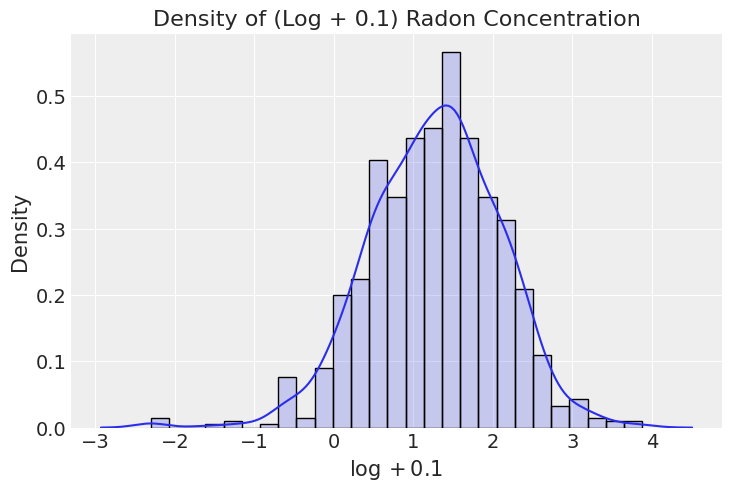

In [4]:
fig, ax = plt.subplots()
sns.histplot(x="log_radon",  alpha=0.2, stat="density", data=srrs_mn, ax=ax)
sns.kdeplot(x="log_radon", data=srrs_mn, ax=ax)
ax.set(title="Density of (Log + 0.1) Radon Concentration", xlabel="$\log + 0.1$", ylabel="Density");

Let us now se the split per `floor`:

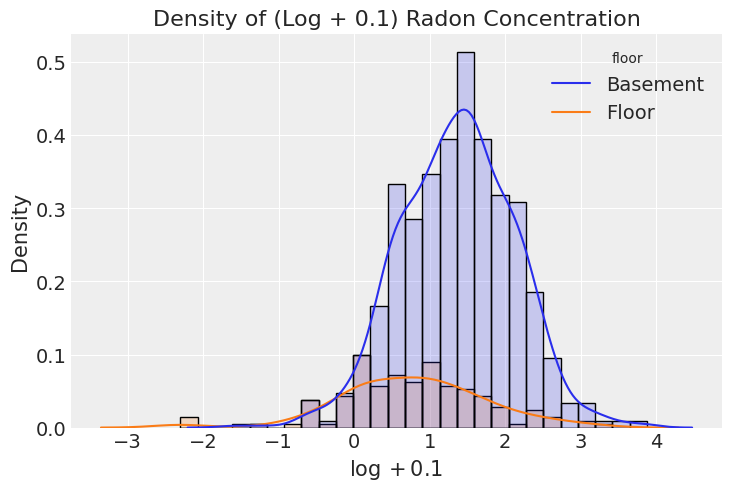

In [5]:
fig, ax = plt.subplots()
sns.histplot(x="log_radon", hue="floor", alpha=0.2, stat="density", data=srrs_mn, ax=ax)
sns.kdeplot(x="log_radon", hue="floor", data=srrs_mn, ax=ax)
ax.set(title="Density of (Log + 0.1) Radon Concentration", xlabel="$\log + 0.1$", ylabel="Density");

Next, let us count the number of counties.

In [6]:
print(f"Number of counties: {srrs_mn['county'].unique().size}")

Number of counties: 85


## Models: Conventional Approaches

### Complete Pooling

Let us start by considering the complete pooling model on which we treat all counties the same and estimate a single radon level for every floor level. That is, We want to estimate the intercept ($\alpha$) and the slope ($\beta$) parameters for the equation:

$$y_i = \alpha + \beta x_i + \varepsilon_i, \quad \text{with} \: i=1, \cdots, n$$

where $y_i$ represents the `log_radon`, $x_i$ represents the `floor` and $\varepsilon \sim N(0, \sigma^2)$ represents the `radon` noise. As we want to make the results of this notebook comparable with the original PyMC article, we want to use the full one-hot-encoding of the `floor` variable. This means that we donot need to add an intercept variable, i.e. set $\alpha$ to zero. Besides the model specification, we also need to set prior distributions for $\beta$ and $\sigma$. We consider the following (as in the PyMC article):

$$
\begin{align*}
\beta & \sim N(0, 10^{2}) \\
\sigma & \sim Exp(1.0)
\end{align*}
$$

Let us now write the Bambi model:

In [7]:
pooled_priors = {
    "floor": bmb.Prior(name="Normal", mu=0.0, sigma=10.0),
    "sigma": bmb.Prior(name="Exponential", lam=1.0),
}

pooled_model = bmb.Model(
    formula="log_radon ~ 0 + floor",
    data=srrs_mn,
    priors=pooled_priors,
    family="gaussian",
    link="identity",
    noncentered=False,
)

pooled_model

Formula: log_radon ~ 0 + floor
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    floor ~ Normal(mu: 0.0, sigma: 10.0)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1.0)

Here are some remarks:

- The formula for the model is `log_radon ~ 0 + floor`. The `0` at the beginning makes sure we remove the intercept.
- We use a non-centered parameterization of the model just to make the results comparable with the original PyMC article.

Let us fit he model now:

In [10]:
pooled_results = pooled_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, floor]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


Let us see the graph representation of the model:

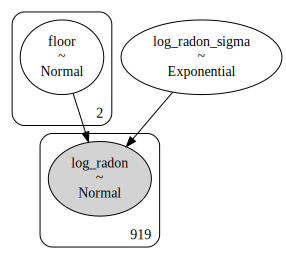

In [12]:
pooled_model.graph()

Now we can examine the posterior distribution of the model parameters:

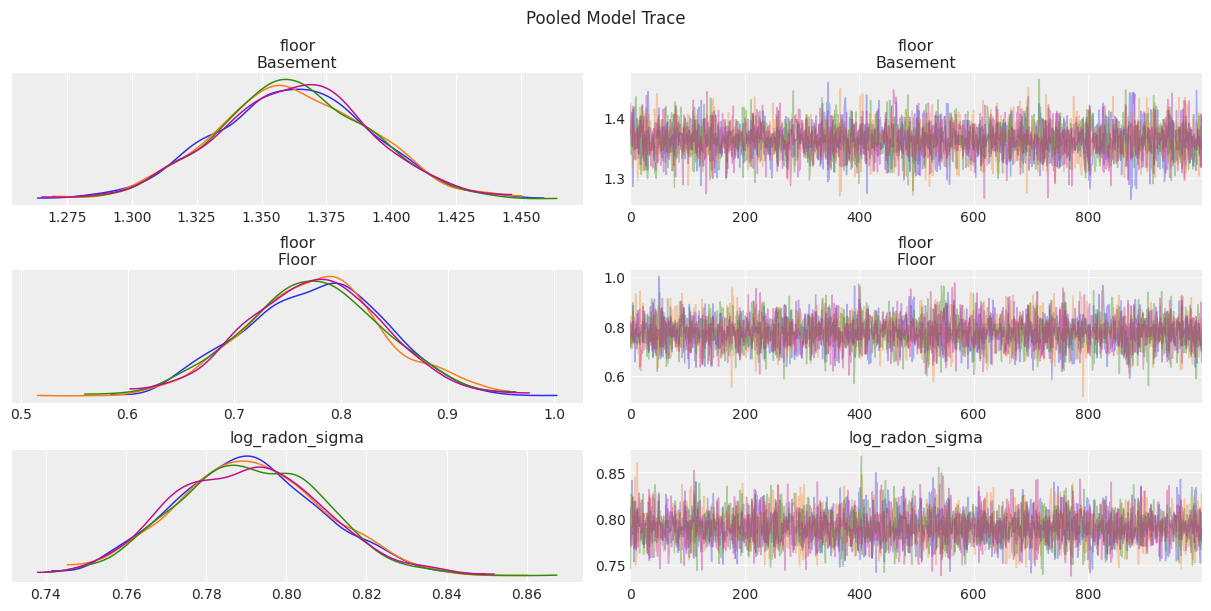

In [27]:
az.plot_trace(data=pooled_results, compact=False);
plt.suptitle("Pooled Model Trace");

We can also plot the distribution of each `floor` level parameter in the same plot.

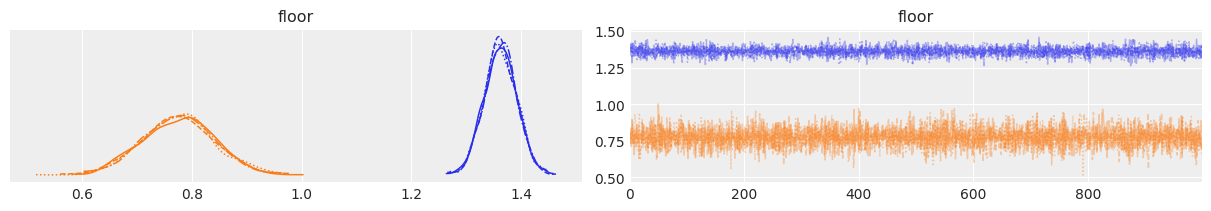

In [37]:
az.plot_trace(data=pooled_results, var_names=["floor"], compact=True);

We can now see some summary statistics. 

In [38]:
az.summary(data=pooled_results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
floor[Basement],1.362,0.029,1.307,1.415,0.000,0.000,5202.0,2346.0,1.0
floor[Floor],0.775,0.065,0.645,0.890,0.001,0.001,5792.0,2945.0,1.0
log_radon_sigma,0.791,0.018,0.755,0.824,0.000,0.000,5975.0,2831.0,1.0


### No Pooling

Next, we consider the model in which radon is modeled in each `county` and `floor` combination independently, i.e. 

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i \quad \text{where} \: j = 1,\ldots,85$$

As above, we actually set $\alpha_{j[i]} = 0$ (as we consider the full one-hot-encoding of the variables). To specify this model in Bambi we can use the formula `log_radon ~ 0 + floor + county + floor*county`. Note that we are removing the intercept with the `0` term and `county:floor` is the multiplicative interaction between `county` and `floor`.

In [ ]:
unpooled_priors = {
    "county:floor": bmb.Prior(name="Normal", mu=0.0, sigma=10.0),
    "sigma": bmb.Prior(name="Exponential", lam=1.0),
}

unpooled_model = bmb.Model(
    formula="log_radon ~ 0 + county:floor",
    data=srrs_mn,
    priors=unpooled_priors,
    family="gaussian",
    link="identity",
    noncentered=False,
)

unpooled_model

In [ ]:
unpooled_results = unpooled_model.fit()

In [ ]:
pm.model_to_graphviz(unpooled_model.backend.model)

In [ ]:
az.summary(data=unpooled_results)

In [ ]:
az.plot_forest(data=unpooled_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

## Multilevel and Hierarchical Models

If you're familiar with the PyMC way of using hierarchies, the Bambi way (borrowed from mixed effects models way) may be a bit confusing in the beginning.
A good explanation is found in Chapter 16 from Bayes Rules book, specifically section 16.3.2. Moreover, you can also take a look into the [Bambi examples section](https://bambinos.github.io/bambi/main/examples.html) where you can fin other use cases.

### Partial Pooling Model

$$y_i = \alpha_{j[i]} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

In [ ]:
partial_pooling_priors = {
    "Intercept": bmb.Prior("Normal", mu=0.0, sigma=10),
    "1|county": bmb.Prior(name="Normal", mu=0.0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior(name="Exponential", lam=1.0),
}

partial_pooling_model = bmb.Model(
    "log_radon ~ 1 + (1|county)", 
    srrs_mn, 
    priors=partial_pooling_priors
)
partial_pooling_model

In [ ]:
partial_pooling_results = partial_pooling_model.fit()

In [ ]:
pm.model_to_graphviz(partial_pooling_model.backend.model)

In [ ]:
az.plot_forest(data=partial_pooling_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

### Varying Intercept Model

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

In [ ]:
varying_intercept_priors = {
    "Intercept": bmb.Prior(name="Normal", mu=0, sigma=10),
    "floor": bmb.Prior(name="Normal", mu=0.0, sigma=10.0),
    "1|county": bmb.Prior(name="Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior(name="Exponential", lam=1),
}

varying_intercept_model = bmb.Model(
    "log_radon ~ 0 + floor + (1|county)",
    srrs_mn,
    priors=varying_intercept_priors,
 )

In [ ]:
varying_intercept_results = varying_intercept_model.fit()

In [ ]:
varying_intercept_model.graph()

In [ ]:
az.plot_forest(data=varying_intercept_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

### Varying Intercept and Slope Model

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$

In [ ]:
varying_intercept_slope_priors = {
    "Intercept": bmb.Prior(name="Normal", mu=0, sigma=5),
    "1|county": bmb.Prior(name="Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "floor|county": bmb.Prior(name="Normal", mu=0.0, sigma=bmb.Prior("Exponential", lam=0.5)),
    "sigma": bmb.Prior(name="Exponential", lam=1.0),
}

varying_intercept_slope_model = bmb.Model(
    formula="log_radon ~ (floor|county)",
    data=srrs_mn,
    priors=varying_intercept_slope_priors,
 )

In [ ]:
varying_intercept_slope_results = varying_intercept_slope_model.fit()

In [ ]:
varying_intercept_slope_model.graph()

In [ ]:
az.plot_forest(data=varying_intercept_slope_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

In [ ]:
az.plot_trace(varying_intercept_slope_results, compact=True, chain_prop={"ls": "-"});

**NOTE:** We can do the following and it "works". But I wouldn't keep this in this notebook because it is still quite experimental and buggy. I'd prefer to fix the implementation and we can update the notebook after that.

In [ ]:
priors = {
    "Intercept": bmb.Prior(name="Normal", mu=0, sigma=5),
    "floor|county": bmb.Prior(name="Normal", mu=0.0, sigma=bmb.Prior("HalfNormal", sigma=0.5)),
    "sigma": bmb.Prior(name="Exponential", lam=1.0),
}

model = bmb.Model(
    formula="log_radon ~ (0 + floor|county)",
    data=srrs_mn,
    priors=priors,
    priors_cor={"county": 2}
 )

model.build()

In [ ]:
model.graph()

In [ ]:
idata = model.fit()

In [ ]:
az.plot_trace(idata);